In [14]:
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import s3fs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord 
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.time import Time
import warnings
from astropy.wcs import FITSFixedWarning
from upath import UPath

print('Imported Libraries')

Imported Libraries


In [2]:
pan_x_gaia = pd.read_csv('gaia_x_pan.csv')
pan_x_gaia

,_healpix_29,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,phot_g_mean_mag_gaia,phot_bp_mean_mag_gaia,phot_rp_mean_mag_gaia,objName_panstarrs,...,yMeanKronMag_panstarrs,yMeanKronMagErr_panstarrs,yMeanKronMagStd_panstarrs,yMeanKronMagNpt_panstarrs,yMeanApMag_panstarrs,yMeanApMagErr_panstarrs,yMeanApMagStd_panstarrs,yMeanApMagNpt_panstarrs,yFlags_panstarrs,_dist_arcsec
0,72355622838789655,144711230753602048,68.900732,21.250996,860.716142,-959.207910,19.120424,21.595911,17.604784,PSO J068.9006+21.2508,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,0,0.935582
1,279061151160369797,558122277038055808,83.298901,82.771826,2038.794128,-1662.957624,NaN,NaN,18.495470,PSO J083.2893+82.7728,...,17.063000,0.007696,0.012025,2,16.966000,0.033538,0.059012,2,16696,5.729679
2,465411006967832544,930822015518055808,127.527141,48.476428,-1016.564527,-774.971624,20.710526,21.585167,19.048940,PSO J127.5276+48.4767,...,17.316999,0.064702,-999.000000,1,17.201300,0.039123,-999.000000,1,16777496,1.466545
3,794625047801153335,1589250088362827776,228.747226,48.801312,-938.043889,1464.629578,19.241777,21.351543,17.604332,PSO J228.7477+48.8008,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,0,2.486244
4,847595661249829565,1695191332232990720,226.702636,70.461619,-1194.179224,1042.194214,20.199528,21.771992,18.331950,PSO J226.7031+70.4613,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,16416,1.192280
5,1141806263107329672,2283612503305198208,321.760630,76.299039,756.414332,822.462560,19.926235,21.453360,18.204111,PSO J321.7594+76.2988,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,0,1.397489
6,1286450513388042213,2572901021957789568,24.241250,9.563070,1238.243937,-16.155572,19.461197,21.107285,17.640982,PSO J024.2408+09.5631,...,15.849600,0.012058,-999.000000,1,15.771600,0.007937,-999.000000,1,16696,1.575092
7,1819280488241997640,3638560954457699200,202.951993,-1.285494,-414.209178,-1041.278255,20.534954,21.398540,18.914696,PSO J202.9522-01.2850,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,0,1.850107
8,1849489717977963240,3698979462002285824,180.986807,0.262663,-1219.590296,-282.117684,19.133556,20.761082,17.564669,PSO J180.9871+00.2627,...,16.221901,0.008936,-999.000000,1,16.189199,0.005774,-999.000000,1,280,2.243032
9,1948178546855350528,3896357089270247168,179.588931,4.579897,570.395737,-923.194122,20.678568,21.712635,19.082453,PSO J179.5888+04.5802,...,-999.000000,-999.000000,-999.000000,0,-999.000000,-999.000000,-999.000000,0,0,1.197163


In [15]:
def getimages(ra,dec,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}&type=warp&format=fits&size=40"
    print(url)
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", img_type='warp',color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}&type={img_type}")
    
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    print(url)
    return url

def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

def truncate(x):
    if np.isnan(x): return x
    return int(x * 1000) / 1000

In [47]:
def plot_imgs_with_gaia_vec(image_table, ra, dec, pm_ra, pm_dec, mag):
    num_imgs = len(image_table)
    print(num_imgs)
    if num_imgs < 4:
        return

    # Step 1: Extract dates and store with indices
    date_index_list = []
    for idx, row in enumerate(image_table):
        url = UPath('https://ps1images.stsci.edu' + row['filename'])
        file_path = UPath('./ps1_images' + row['filename'])
        file_path.parent.mkdir(exist_ok=True, parents=True)
        if not file_path.exists():
            with url.open('rb') as src, file_path.open('wb') as dest:
                dest.write(src.read())
            # url.open.read()(file_path)
        with fits.open(file_path.open('rb')) as hdul:
            hdr = hdul[1].header
        #display(hdr)
        obs_date_mjd = hdr['MJD-OBS']
        date_index_list.append((obs_date_mjd, idx, hdr))  # Save header to avoid reloading

    # Step 2: Sort by date
    date_index_list.sort()

    # Prepare figure
    target_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    cols = int(np.ceil(np.sqrt(num_imgs)))
    rows = int(np.ceil(num_imgs / cols))
    fig = plt.figure(figsize=(, 16))
    fig.suptitle(f"Pan-STARRS High PM Star Images, g band\n RA:{truncate(ra)}, DEC:{truncate(dec)}, Gaia-Mag:{truncate(mag)}", 
                 fontsize=28, y=0.96)

    for plot_idx, (date_obj, original_idx, hdr) in enumerate(date_index_list):
        # Reload row and image
        # url = UPath('https://ps1images.stsci.edu/') / row['filename']
        row = image_table[original_idx]
        file_path = UPath('./ps1_images/' + row['filename'])
        with fits.open(file_path.open('rb')) as hdul:
            hdr = hdul[1].header
            image = hdul[1].data
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FITSFixedWarning)
            wcs = WCS(hdr)
        obs_date = Time(date_obj, format='mjd').to_datetime()


        # Create subplot
        cutout = Cutout2D(image, target_coord, 10 * u.arcsec, wcs=wcs)
        ax = fig.add_subplot(rows, cols, plot_idx + 1, projection=cutout.wcs)
        im = ax.imshow(cutout.data, origin='lower', vmin=0, vmax=20)
        # im = ax.imshow(image, origin='lower', vmin=0, vmax=100)
        ax.set_xlabel('DEC')
        ax.set_ylabel('RA', labelpad=-1)
        ax.set_title(f'Date: {obs_date}', fontsize=16)
        fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8)

        # Gaia Vector
        pm_ra_cosdec = pm_ra / np.cos(np.radians(dec))
        coord = SkyCoord(ra=ra * u.deg,
                         dec=dec * u.deg,
                         pm_ra_cosdec=pm_ra_cosdec * u.mas/u.yr,
                         pm_dec=pm_dec * u.mas/u.yr, obstime='J2010')
        new_coord = coord.apply_space_motion(new_obstime=Time('J2013'))

        end_vec = skycoord_to_pixel(new_coord, cutout.wcs)
        origin = skycoord_to_pixel(coord, cutout.wcs)
        vec = np.array(end_vec) - np.array(origin)
        ax.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color='red', zorder=10)
        # ax.plot(*origin, marker='o', color='red', markersize=10, zorder=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

SyntaxError: invalid syntax (3453642337.py, line 30)

https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=68.90057683&dec=21.25078044&filters=i&type=warp&format=fits&size=40
30


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

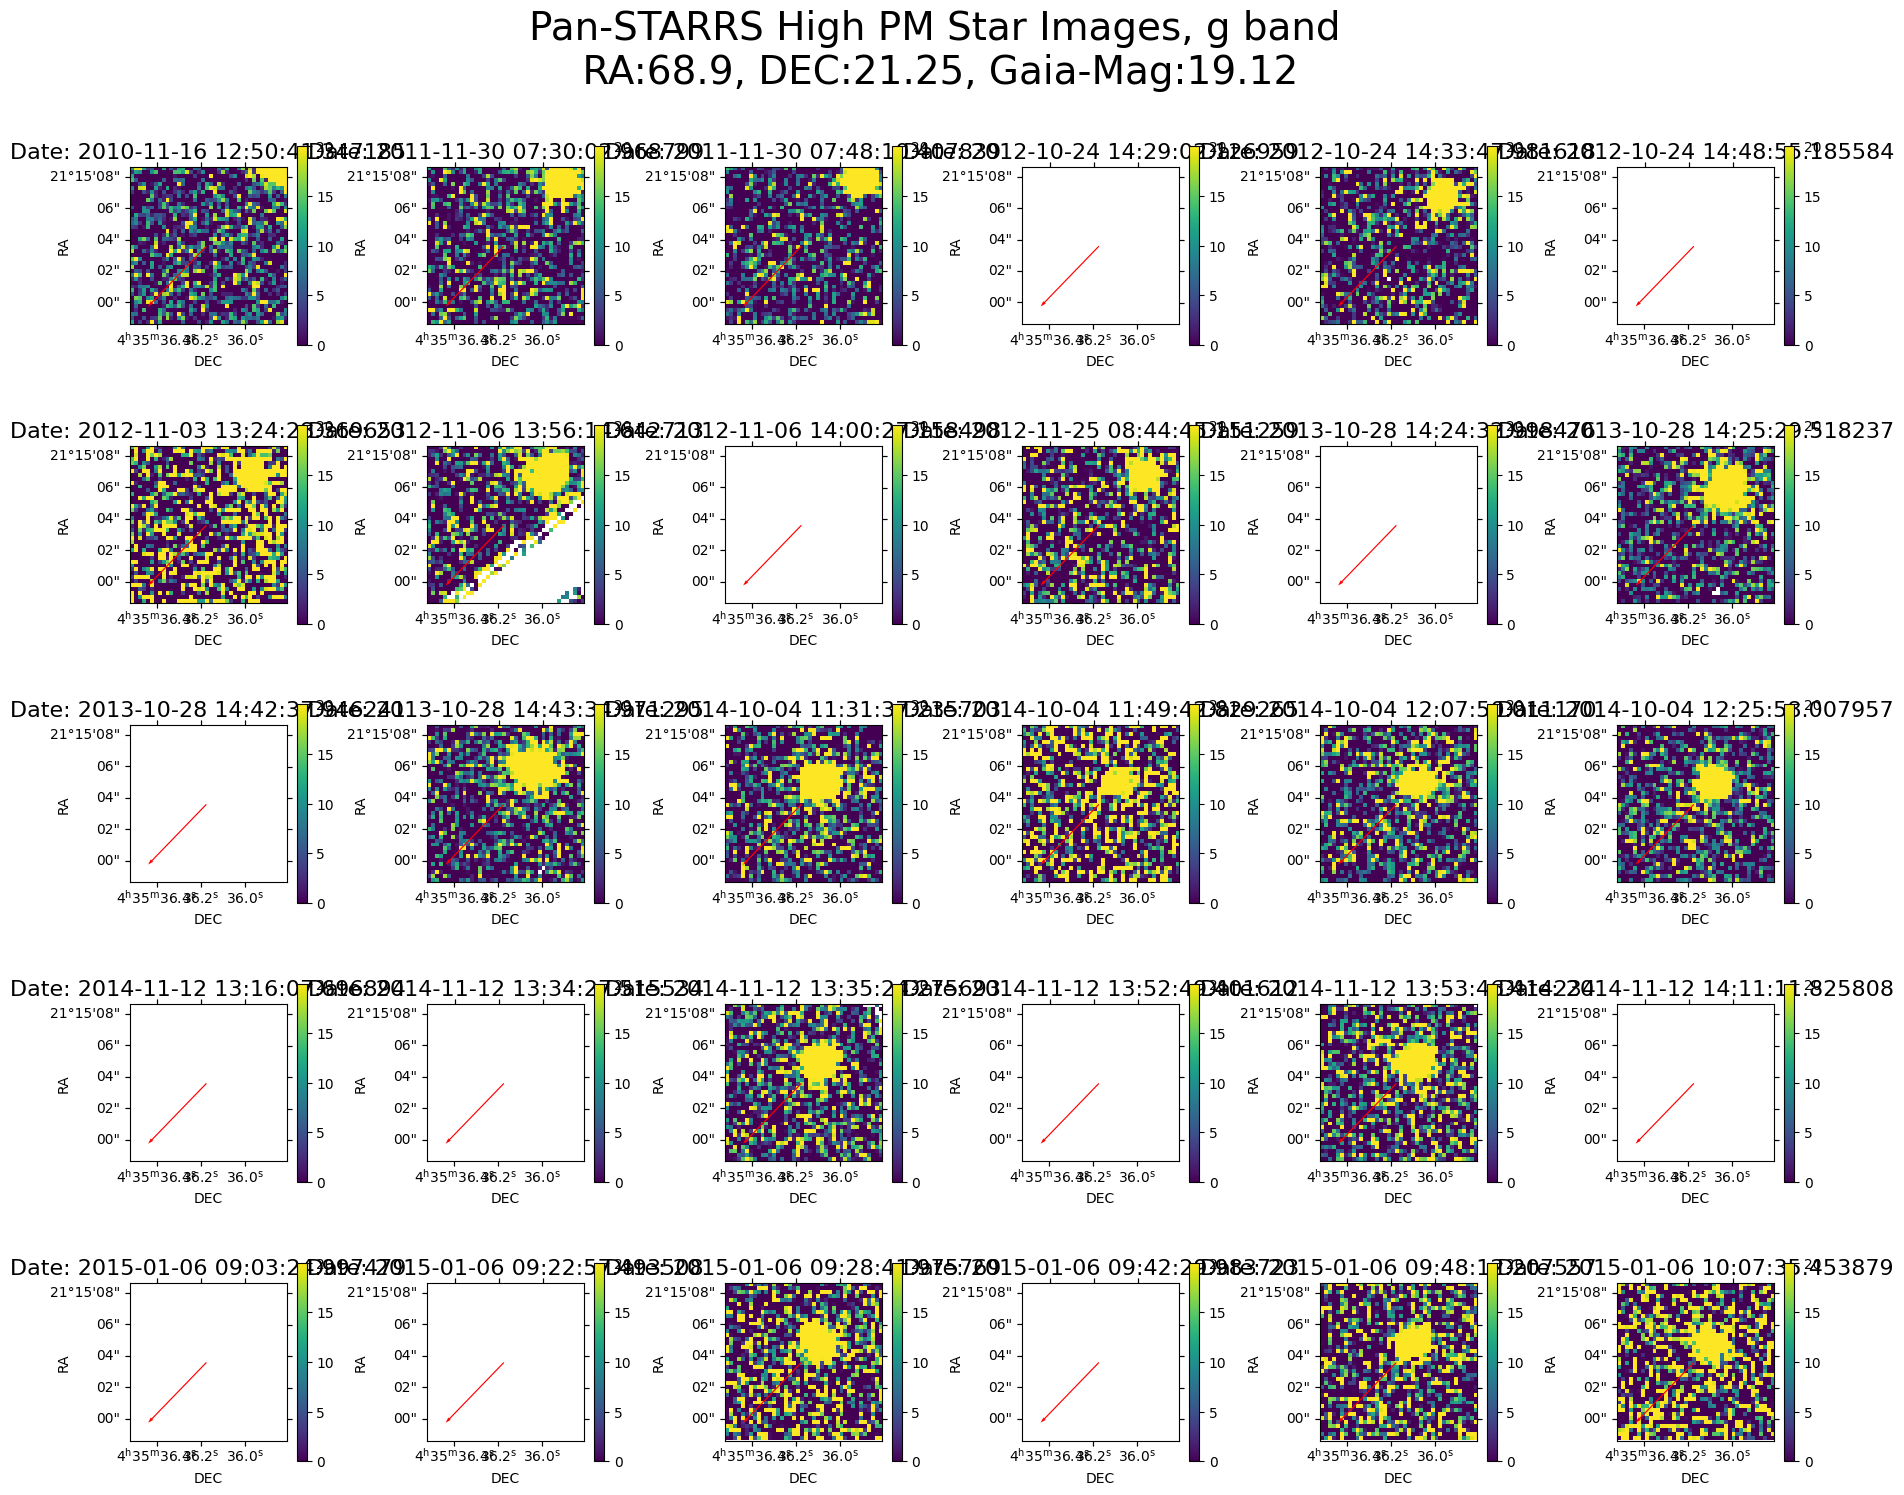

https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=83.28914076510203&dec=82.77283863891671&filters=i&type=warp&format=fits&size=40
21


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

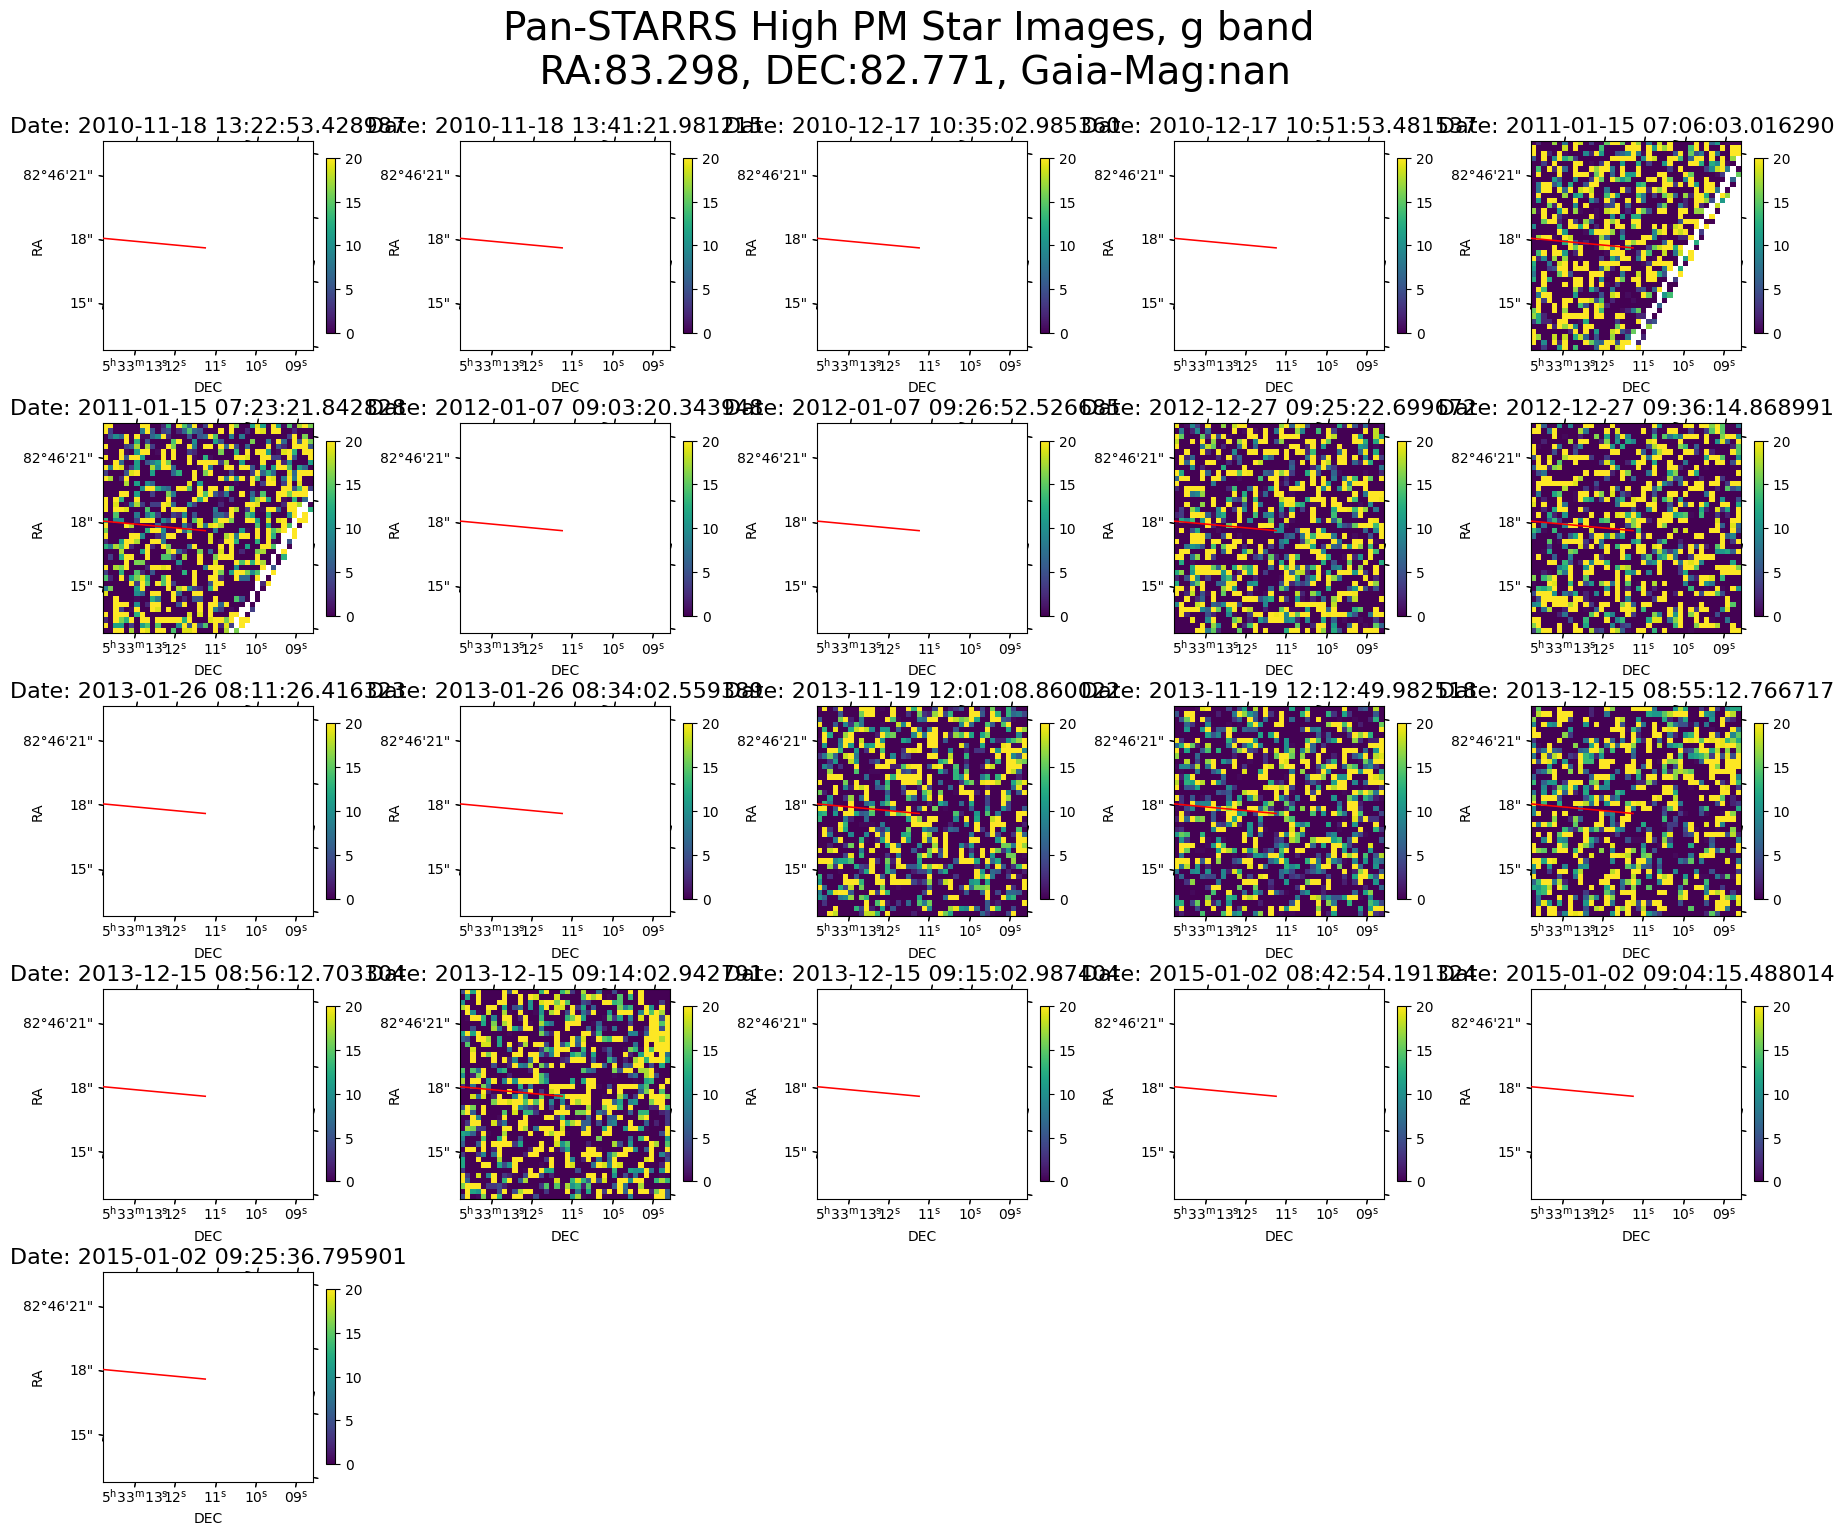

https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=127.52763352842187&dec=48.47667125409052&filters=i&type=warp&format=fits&size=40
33


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

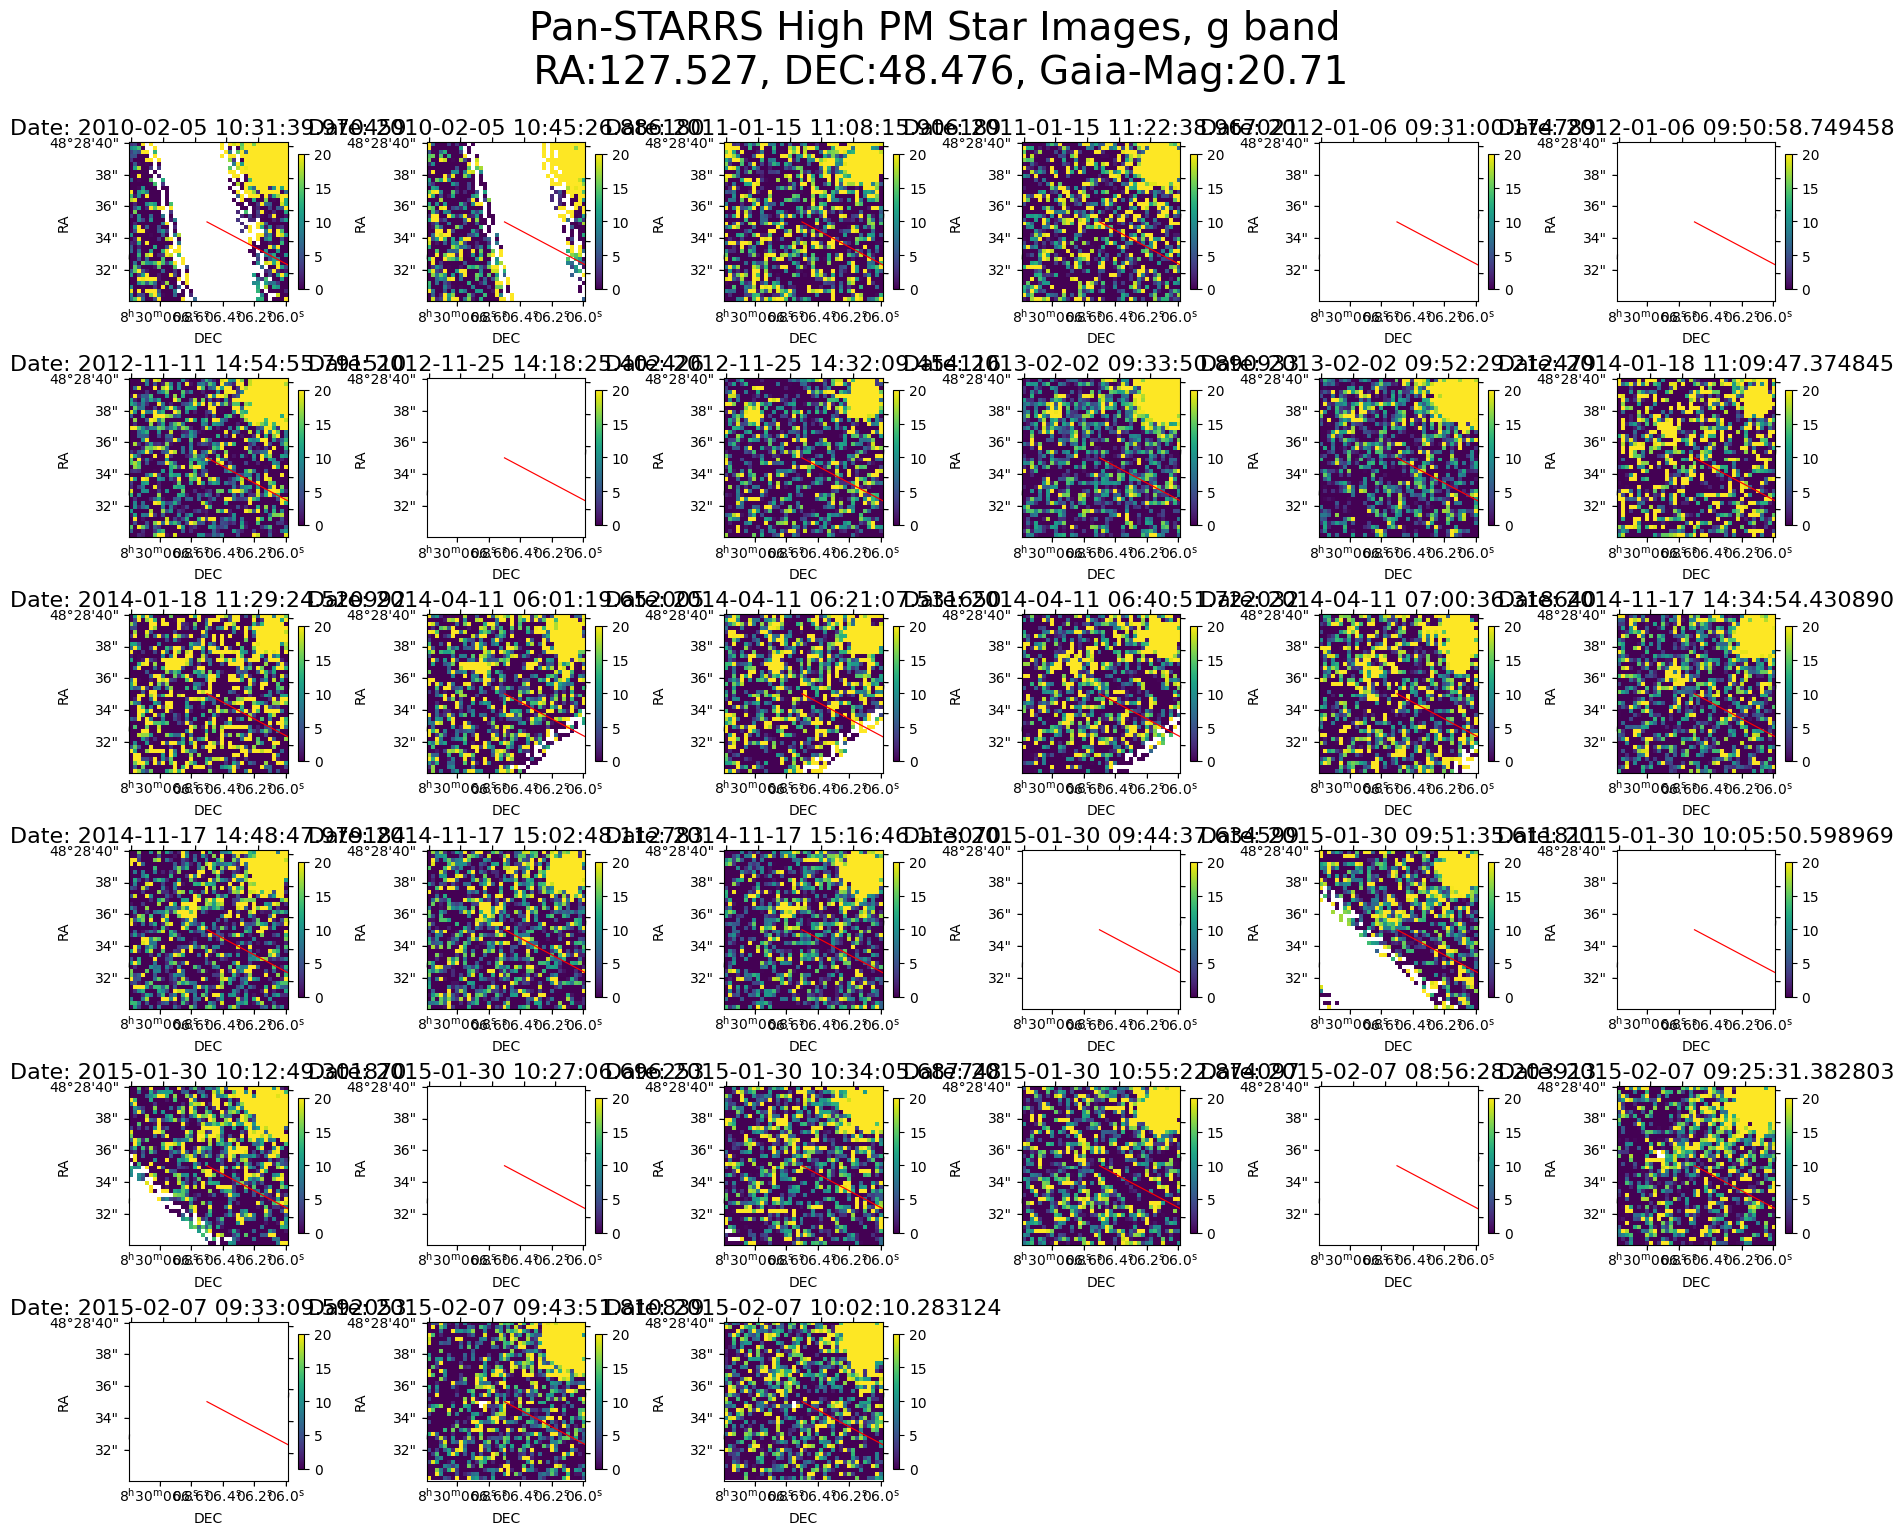

https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=228.74777097865447&dec=48.80072246955244&filters=i&type=warp&format=fits&size=40
29


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarni

KeyboardInterrupt: 

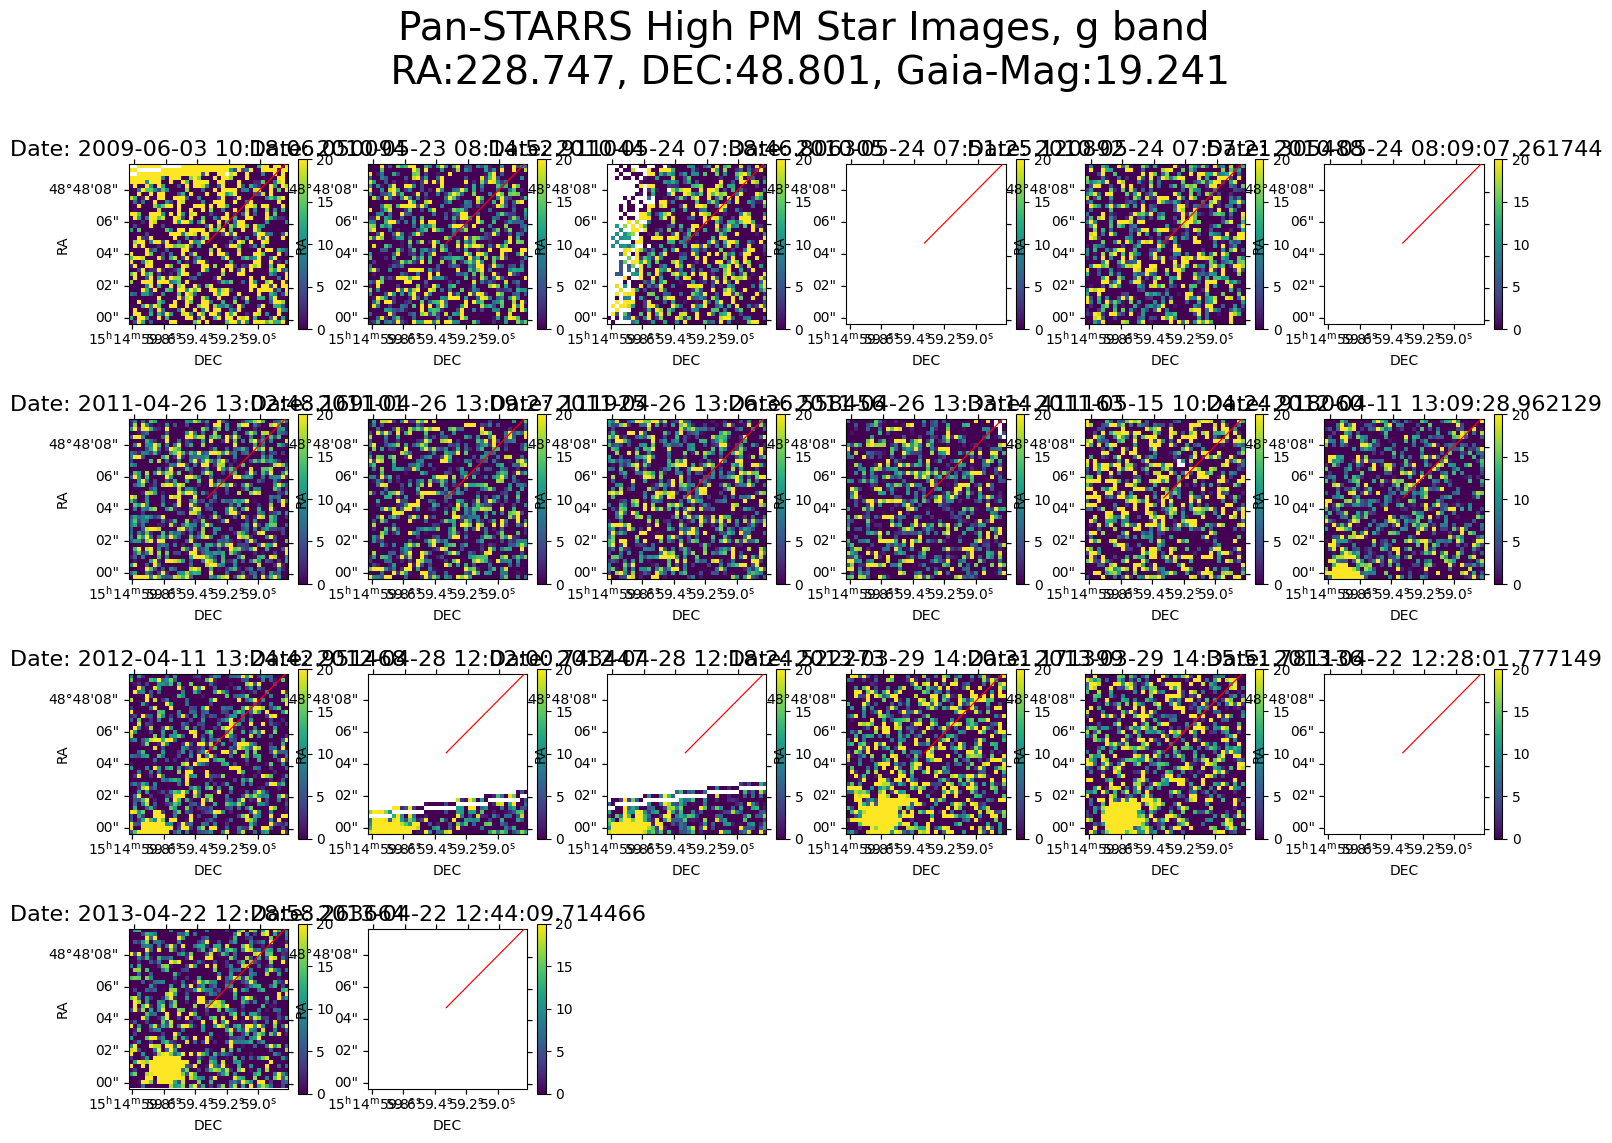

In [46]:
for index, row in pan_x_gaia.iterrows():
    # 0.5 arcsecs per pixel, so 10 arcsec images
    images = getimages(row['raMean_panstarrs'], row['decMean_panstarrs'], filters='i')
    plot_imgs_with_gaia_vec(images, row['ra_gaia'], row['dec_gaia'], row['pmra_gaia'], row['pmdec_gaia'], row['phot_g_mean_mag_gaia'])

In [38]:
file_path = UPath('ps1_images/rings.v3.skycell/1780/034/rings.v3.skycell.1780.034.wrp.g.55889_52686.fits')


with fits.open(file_path.open('rb')) as hdul:
    hdr = hdul[1].header

display(hdr)

SIMPLE  =                    T / Uncompressed file's conforms to FITS           
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 6279 / length of original image axis                  
NAXIS2  =                 6261 / length of original image axis                  
NPLYTERM=                    0                                                  
HISTORY pswarp at 2015-01-31T06:27:28.258074                                    
PSLIB_V = '37083   '                                                            
HISTORY psLib version: tags/ipp-pv3-20140717/psLib@37083                        
HISTORY psLib source: 60eb6cdc-a59c-4636-a4e0-dba66a9721fd                      
MODULE_V= '37083   '                                                            
HISTORY psModules version: tags/ipp-pv3-20140717/psModules@37083                
HISTORY psModules source: 60